## LETK Filtering


In [1]:
import Simulator
import Observation
import Statistics
import LETKalmanFilter

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_11-14_10_29"

grid, simulator = Simulator.from_file(timestamp)

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [7]:
statistics = Statistics.Statistics(simulator, N_e=100)

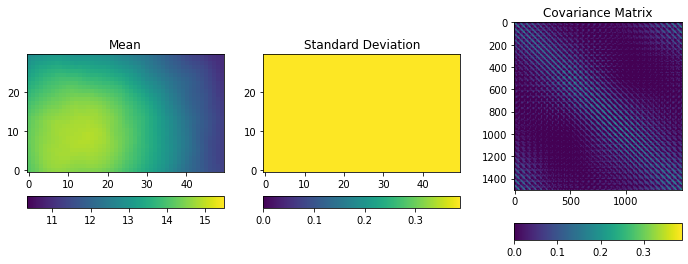

In [8]:
prior_args = Statistics.prior_args_from_file(timestamp)
statistics.set_prior(prior_args)

statistics.plot()

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [9]:
obs_timestamp = "2021_08_11-14_10_37"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


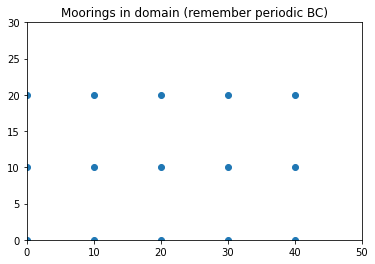

In [10]:
observation.plot_positions()

## LETKF filtering

Updating/conditioning the distributions at every observation time

In [12]:
letkFilter = LETKalmanFilter.LETKalman(statistics, observation, 5)

In [13]:
letkFilter.groups

[[0, 2, 6, 8, 14], [1, 4, 5, 7, 13], [11, 3, 9], [10, 12]]

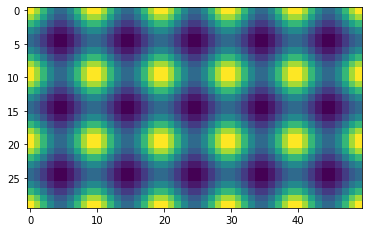

In [13]:
from matplotlib import pyplot as plt
plt.imshow(letkFilter.W_analysis)

In [14]:
statistics.propagate(25)

0


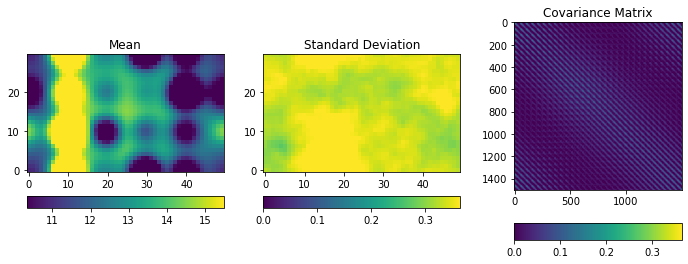

1


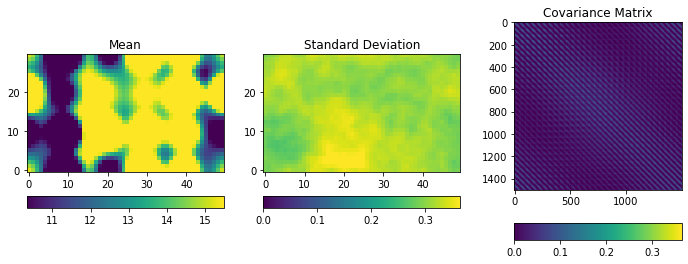

2


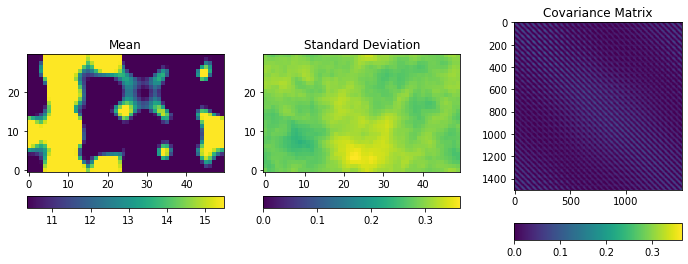

3


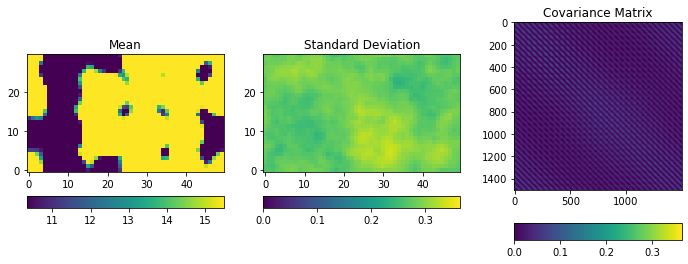

4


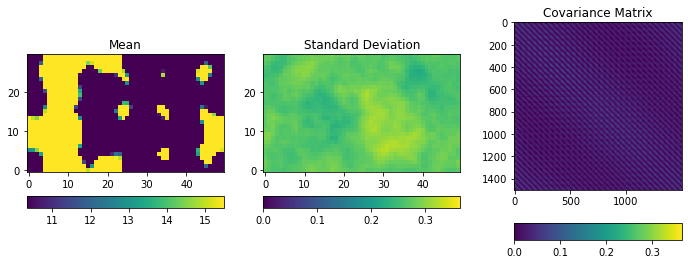

5


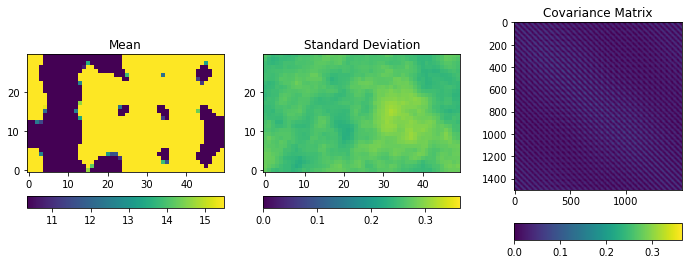

6


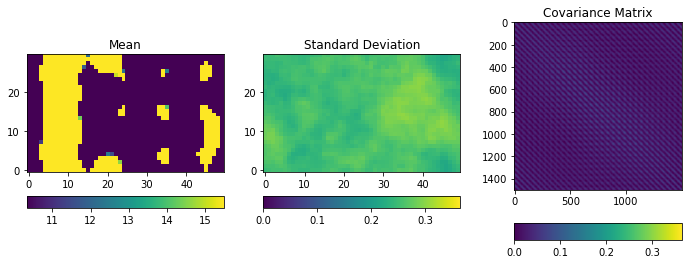

7


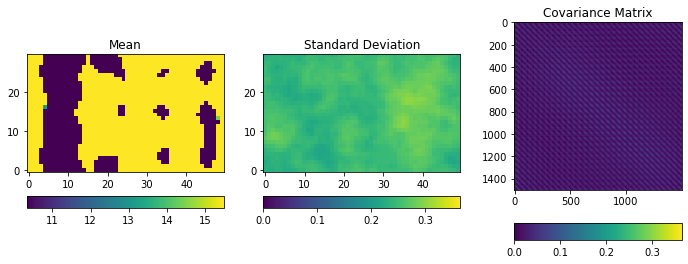

8


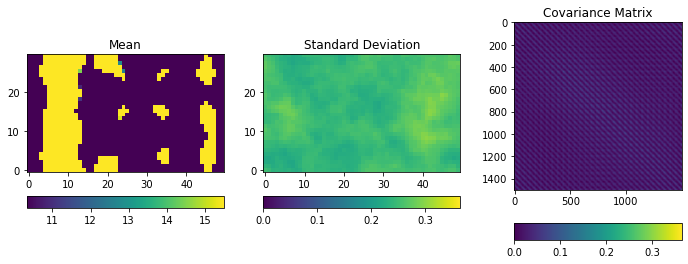

9


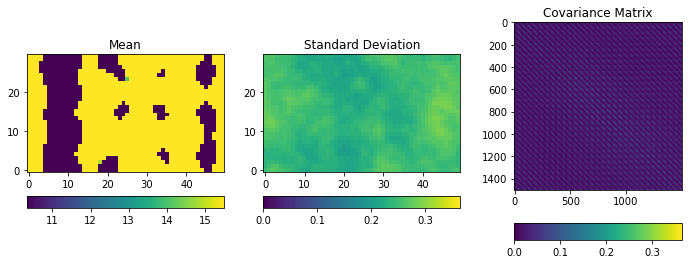

In [15]:
for t in range(observation.N_obs):
    print(t)
    statistics.propagate(25)
    letkFilter.filter(statistics.ensemble.ensemble, observation.obses[t])
    statistics.plot()